## Section 1 - Anomaly Detection 
In this notebook, we will focus on identifying anomalies in a data set. We will integrate data exploration, and we will also use anomaly detection algorithms to extract graphs and conclusions from them.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import IsolationForest

In [2]:
df = pd.read_csv('Tavily Data Analysis Home Test - Time Series.csv')
print(df.head())

             DATE_TIME  VOLUME  RESP_AVG
0   2025-03-22 8:00:00     442  7.085964
1   2025-03-22 9:00:00     418  8.405124
2  2025-03-22 11:00:00     507  7.779719
3  2025-03-22 12:00:00     559  6.877425
4  2025-03-22 13:00:00     602  8.178685


In [3]:
#Understanding the data 
df = df.set_index('DATE_TIME')
df.index = pd.to_datetime(df.index)
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1706 entries, 2025-03-22 08:00:00 to 2025-06-15 07:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   VOLUME    1706 non-null   int64  
 1   RESP_AVG  1706 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 40.0 KB
None
             VOLUME     RESP_AVG
count   1706.000000  1706.000000
mean    2640.644197     7.848615
std     2410.114417     2.171984
min      362.000000     4.594024
25%     1136.000000     6.904281
50%     2052.500000     7.694853
75%     3297.000000     8.506829
max    23259.000000    64.354239


In [4]:
df['log_VOLUME'] = np.log(df['VOLUME'])
df['resp_per_logreq'] = df['RESP_AVG'] / df['log_VOLUME']


df['z_resp_per_logreq'] = (
    df['resp_per_logreq'] - df['resp_per_logreq'].mean()
) / df['resp_per_logreq'].std()

In [5]:
df.head()

,VOLUME,RESP_AVG,log_VOLUME,resp_per_logreq,z_resp_per_logreq
DATE_TIME,,,,,
2025-03-22 08:00:00,442,7.085964,6.091310,1.163291,0.401740
2025-03-22 09:00:00,418,8.405124,6.035481,1.392619,1.133420
2025-03-22 11:00:00,507,7.779719,6.228511,1.249050,0.675357
2025-03-22 12:00:00,559,6.877425,6.326149,1.087142,0.158785
2025-03-22 13:00:00,602,8.178685,6.400257,1.277868,0.767304


## IsolationForest model to identify Anomaly's

In [7]:
#define the Isolation Forest model
model = IsolationForest(contamination=0.05, random_state=42)

# Fit the model to the data
model.fit(df[['resp_per_logreq','z_resp_per_logreq']])

# Predict anomalies
df['anomaly'] = model.predict(df[['resp_per_logreq','z_resp_per_logreq']])


Intermediate step - we will build a new df that will consist of the anomaly values ​​and whether the observations were identified as an anomaly.

We will want to separate the original dataframe so as not to touch it, in addition to working on a new one with the values ​​​​that were output to display the final content

In [9]:
df['is_anomaly'] = df['anomaly'] == -1
df['anomaly_score'] = model.decision_function(df[['resp_per_logreq','z_resp_per_logreq']])

#create saperate dataframes for anomalies and normal points
df_anomalies = df[df['is_anomaly']]

In [16]:
df_anomalies

,VOLUME,RESP_AVG,log_VOLUME,resp_per_logreq,z_resp_per_logreq,anomaly,is_anomaly,anomaly_score
DATE_TIME,,,,,,,,
2025-03-24 03:00:00,886,13.432887,6.786717,1.979291,3.005224,-1,True,-0.164023
2025-03-24 05:00:00,518,8.886471,6.249975,1.421841,1.226656,-1,True,-0.000101
2025-03-24 09:00:00,1011,9.745900,6.918695,1.408633,1.184514,-1,True,-0.003694
2025-03-24 11:00:00,611,9.197875,6.415097,1.433786,1.264766,-1,True,-0.005296
2025-03-24 15:00:00,1178,10.025484,7.071573,1.417716,1.213496,-1,True,-0.000506
...,...,...,...,...,...,...,...,...
2025-06-14 04:00:00,2286,5.049164,7.734559,0.652806,-1.226985,-1,True,-0.060094
2025-06-14 05:00:00,2230,4.960932,7.709757,0.643461,-1.256798,-1,True,-0.077278
2025-06-14 15:00:00,2826,5.162550,7.946618,0.649654,-1.237042,-1,True,-0.066450


## visializtion 

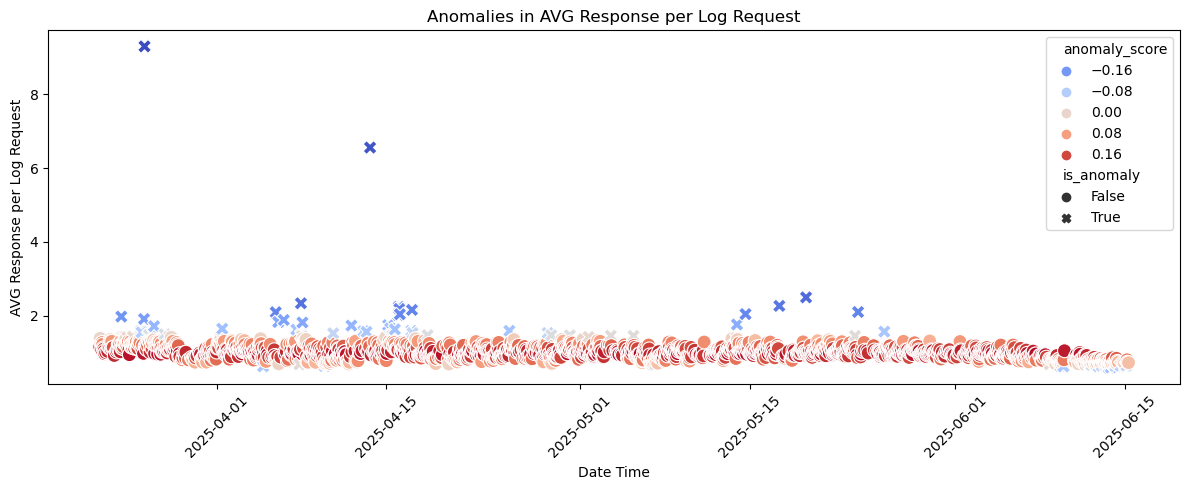

In [19]:
#ploting the anomalies 
plt.figure(figsize=(12, 5))
sns.scatterplot(x='DATE_TIME',y='resp_per_logreq',data=df,hue='anomaly_score',style='is_anomaly',palette='coolwarm',s=100)
plt.title('Anomalies in AVG Response per Log Request')
plt.xlabel('Date Time')
plt.ylabel('AVG Response per Log Request')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Identification of anomalies, explanation of them (conclusions), and suggestions for optimization
We will now analyze 2 major anomalies that can be distinguished without question. Both are marked with a blue X, the first before April (March area), while the second is towards mid-April.

The x-axis is the duration of our observations, while the y-axis is the ratio of the average response time of the system to the number of requests received after normalization with logarithms.

1. First anomaly - March, it crosses the average to over 8. In the initial analysis we performed in the eda stage, it was possible to observe a seasonal analysis that there is a significant and volatile increase in March in the analysis of the given time series. It occurs mainly in the middle of the week in the weekly distribution of March and is performed twice in the evening and at night.
First conclusion - the effect of leaving and entering the weekend. The average response time of the system is apparently affected by a large load/incoming of requests, which causes these values ​​to significantly exceed and jump up.

2. Second anomaly - April. An anomaly that is trying to rise and approach the peak of the previous month.
It can be seen from the graph analysis that the ratio of average response time to the number of requests in April is significantly greater than in other months. Before the sharp increase in the anomaly, we want attempts to increase but without success. There is something that breaks them until the middle of the month. Apparently, high traffic entering the system manages to cause congestion and an increase.

# Methods for correcting anomalies and is it worth it?
## My opinion on fixing anomalies in time series:
As for real events such as external events of server load or user requests, I think it is better to leave the anomalies for a model to handle them.
Sometimes they are not always an error that was created, but a real event that the model will address instead of rejecting and eliminating them.

You can address business or seasonal events:
For example, specific weeks of Black Friday sales. There will be exceptions that are not a natural part of the system's behavior.
Once we remove these anomalies, our model will only learn from normal periods and its import index will always be significantly low at critical moments that are important for learning. In the end, this will lead to unrealistic predictions.

In conclusion, analyzing events in time series of the ratio between the average time of the system's response to the number of requests that entered, is a significant thing that can draw important conclusions from a business perspective and from the perspective of improving our model.
For this purpose, I chose to refer to the issue as failure to correct anomalies in my observations.